In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette("deep")

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

In [72]:
bikes_df = pd.read_csv("data/day.csv")
bikes_df.shape

(730, 16)

### Analysing data using EDA

#### Fix rows/columns
Fix any nulls or duplicates values. Remove any unwanted columns

In [73]:
# No null columns
(bikes_df.isna().sum() > 0).sum()

0

In [74]:
print(bikes_df['instant'].nunique())
bikes_df.drop('instant', axis=1, inplace=True)

730


In [75]:
bikes_df = bikes_df.drop_duplicates()
bikes_df.shape

(730, 15)

Certain columns are not useful for our analysis and can be removed
1. dteday: This is the date. We have already have extracted information like month,weekday, holiday, workingday and year. We can safely drop this column
2. registered & casual: Our target variable is cnt which is sum of registered and casual. Therefore these variables are not important in our analysis

In [76]:
bikes_df.drop(['dteday', 'registered','casual'], axis=1, inplace=True)

Lets observe two temperature variables - temp & atemp. As per the definition
1. temp: Temperature in Celsius
2. atemp: Feeling temperature in Celsius

As per the definition of atemp, it depends on external factors like humidity, windspeed etc. This also seems to be heavily correlated to the temp. Hence we can drop this from the analysis. We are already collecting other features like humidity and windspeed

In [77]:
bikes_df[['temp', 'atemp']].corr()

,temp,atemp
temp,1.000000,0.991696
atemp,0.991696,1.000000


In [78]:
bikes_df.drop("atemp", axis=1, inplace=True)

##### Data Standardization 

There are lots of columns which have encoded values like season (0 to 4) or weekday (0 to 6). Lets convert that actual understandable values based on the data dictionary

Season is straight forward
- 1 => spring
- 2 => summer
- 3 => fall
- 4 => winter

In [79]:
bikes_df['season'] = bikes_df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

Weekday is a bit tricky. Usually weekday starts varies from country to country. It may start with Monday for some and Sunday for others. The data dictionary doesn't specify the start. Lets try to infer it from the data. We know for a fact that Sunday is a non working day. We will try to find if weekday = 0 is working day or not. If its a working day then the week starts on Monday otherwise it starts on Sunday

In [80]:
bikes_df[(bikes_df['weekday'] == 0) & bikes_df['workingday'] != 0].shape

(0, 11)

The above code proves that the weekday starts from Sunday

In [81]:
bikes_df['weekday'] = bikes_df['weekday'].map({0:"sun", 1: "mon", 2:"tue", 3:"wed", 4:"thu", 5:"fri", 6:"sat"})

Weathersit is encoded as follows
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [82]:
bikes_df['weathersit'] = bikes_df['weathersit'].map({1:'clear',2:'misty_cloudy',3:'light_rain_snow',4:'heavy_rain_snow'})

In [83]:
bikes_df['mnth'] = bikes_df['mnth'].map({1:'jan',2:'feb',3:'mar',4:'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9: 'sep', 10: 'oct', 11:'nov', 12:'dec'})

##### Filtering Data
Lets look at any outliers and eliminate them if needed

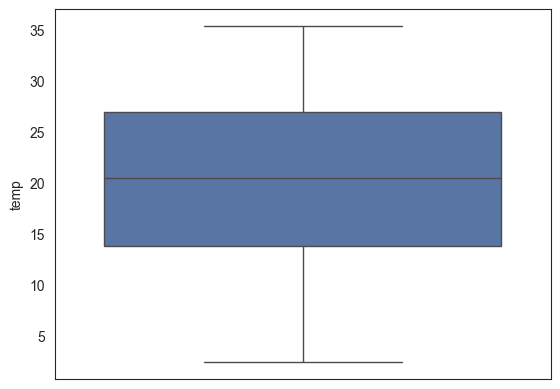

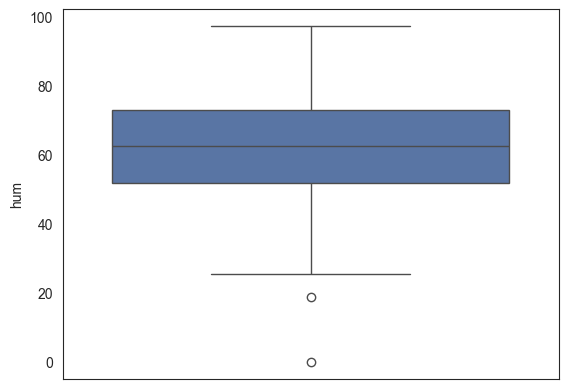

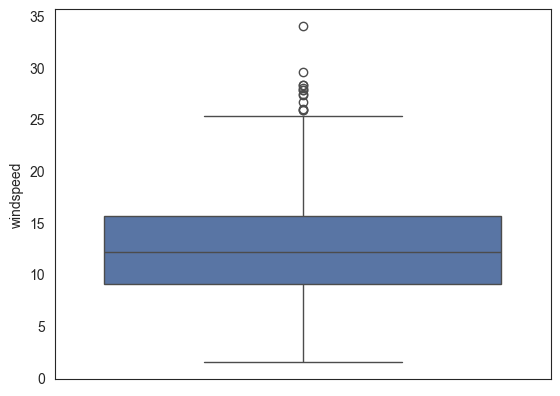

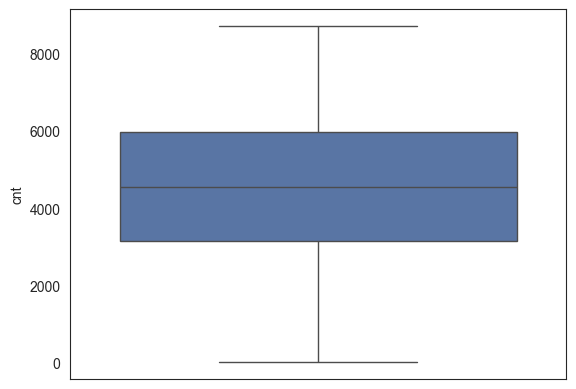

In [84]:
continuous = ["temp", 'hum', 'windspeed','cnt']

for var in continuous:
    sns.boxplot(data=bikes_df, y=var)
    plt.show()

Based on the above plots we can cleary see there are only few outliers. We can live with that and no need to filter any data

##### Univariate / Multivariate Analysis

In [85]:
continuous = ["temp", 'hum', 'windspeed', 'cnt']
cat = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

order_cat = {"season": ["winter", "spring", "summer", "fall"], "weekday": ["sun", 'mon', 'tue','wed', 'thu', 'fri', 'sat']}

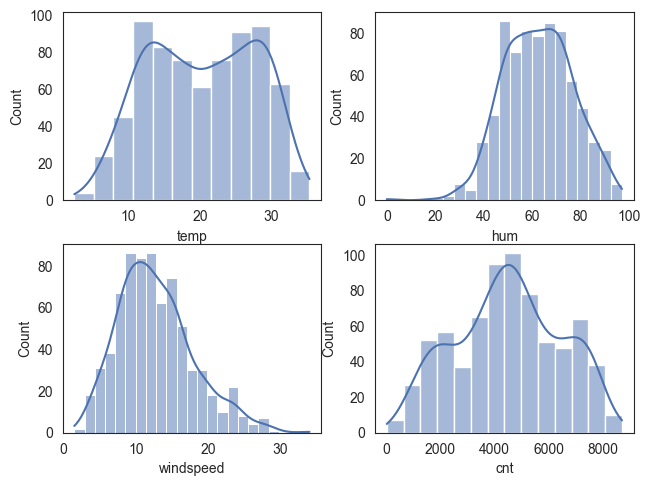

In [86]:
fig, ax = plt.subplots(2,2)
fig.tight_layout()
sns.histplot(data=bikes_df, x=continuous[0], kde=True, ax=ax[0][0])
sns.histplot(data=bikes_df, x=continuous[1], kde=True, ax=ax[0][1])
sns.histplot(data=bikes_df, x=continuous[2], kde=True, ax=ax[1][0])
sns.histplot(data=bikes_df, x=continuous[3], kde=True, ax=ax[1][1])
plt.show()

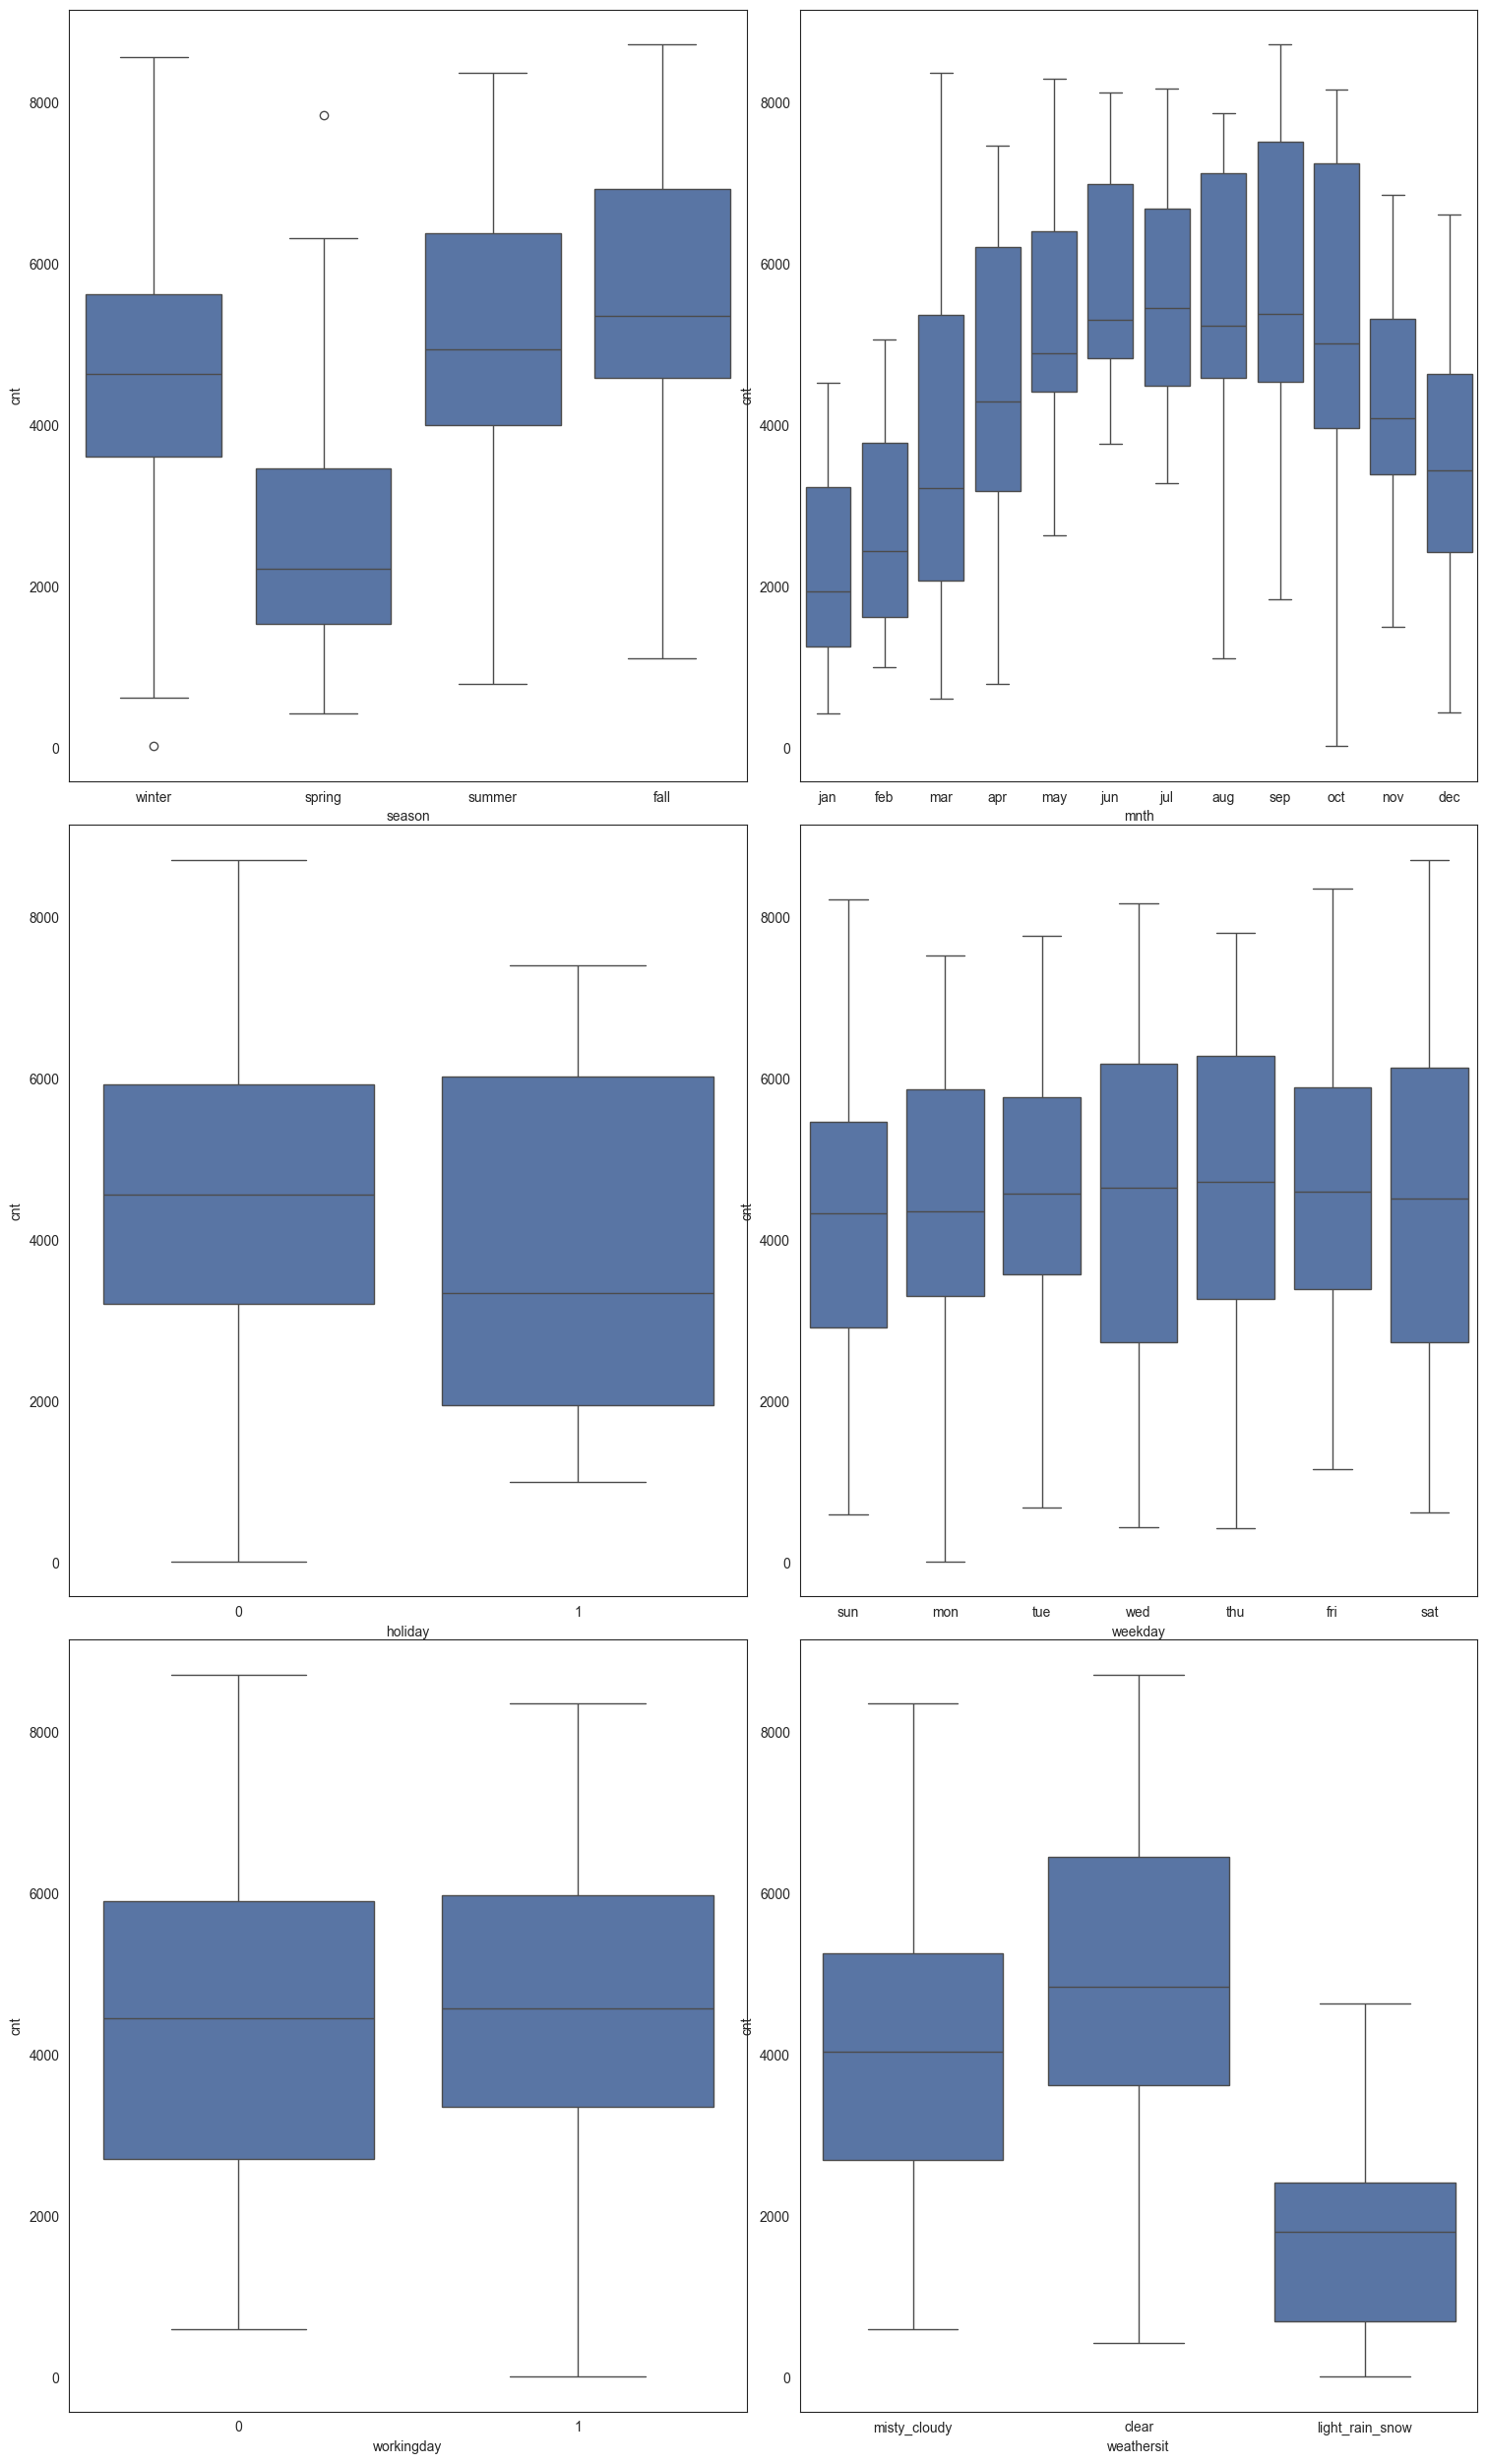

In [87]:
fig, ax = plt.subplots(3,2,figsize=(15, 25))
fig.tight_layout()
sns.boxplot(data=bikes_df, x=cat[0],y="cnt",ax=ax[0][0], order=order_cat.get(cat[0]))
sns.boxplot(data=bikes_df, x=cat[1],y="cnt",ax=ax[0][1], order=order_cat.get(cat[1]))
sns.boxplot(data=bikes_df, x=cat[2],y="cnt",ax=ax[1][0], order=order_cat.get(cat[2]))
sns.boxplot(data=bikes_df, x=cat[3],y="cnt",ax=ax[1][1], order=order_cat.get(cat[3]))
sns.boxplot(data=bikes_df, x=cat[4],y="cnt",ax=ax[2][0], order=order_cat.get(cat[4]))
sns.boxplot(data=bikes_df, x=cat[5],y="cnt",ax=ax[2][1], order=order_cat.get(cat[5]))
plt.show()

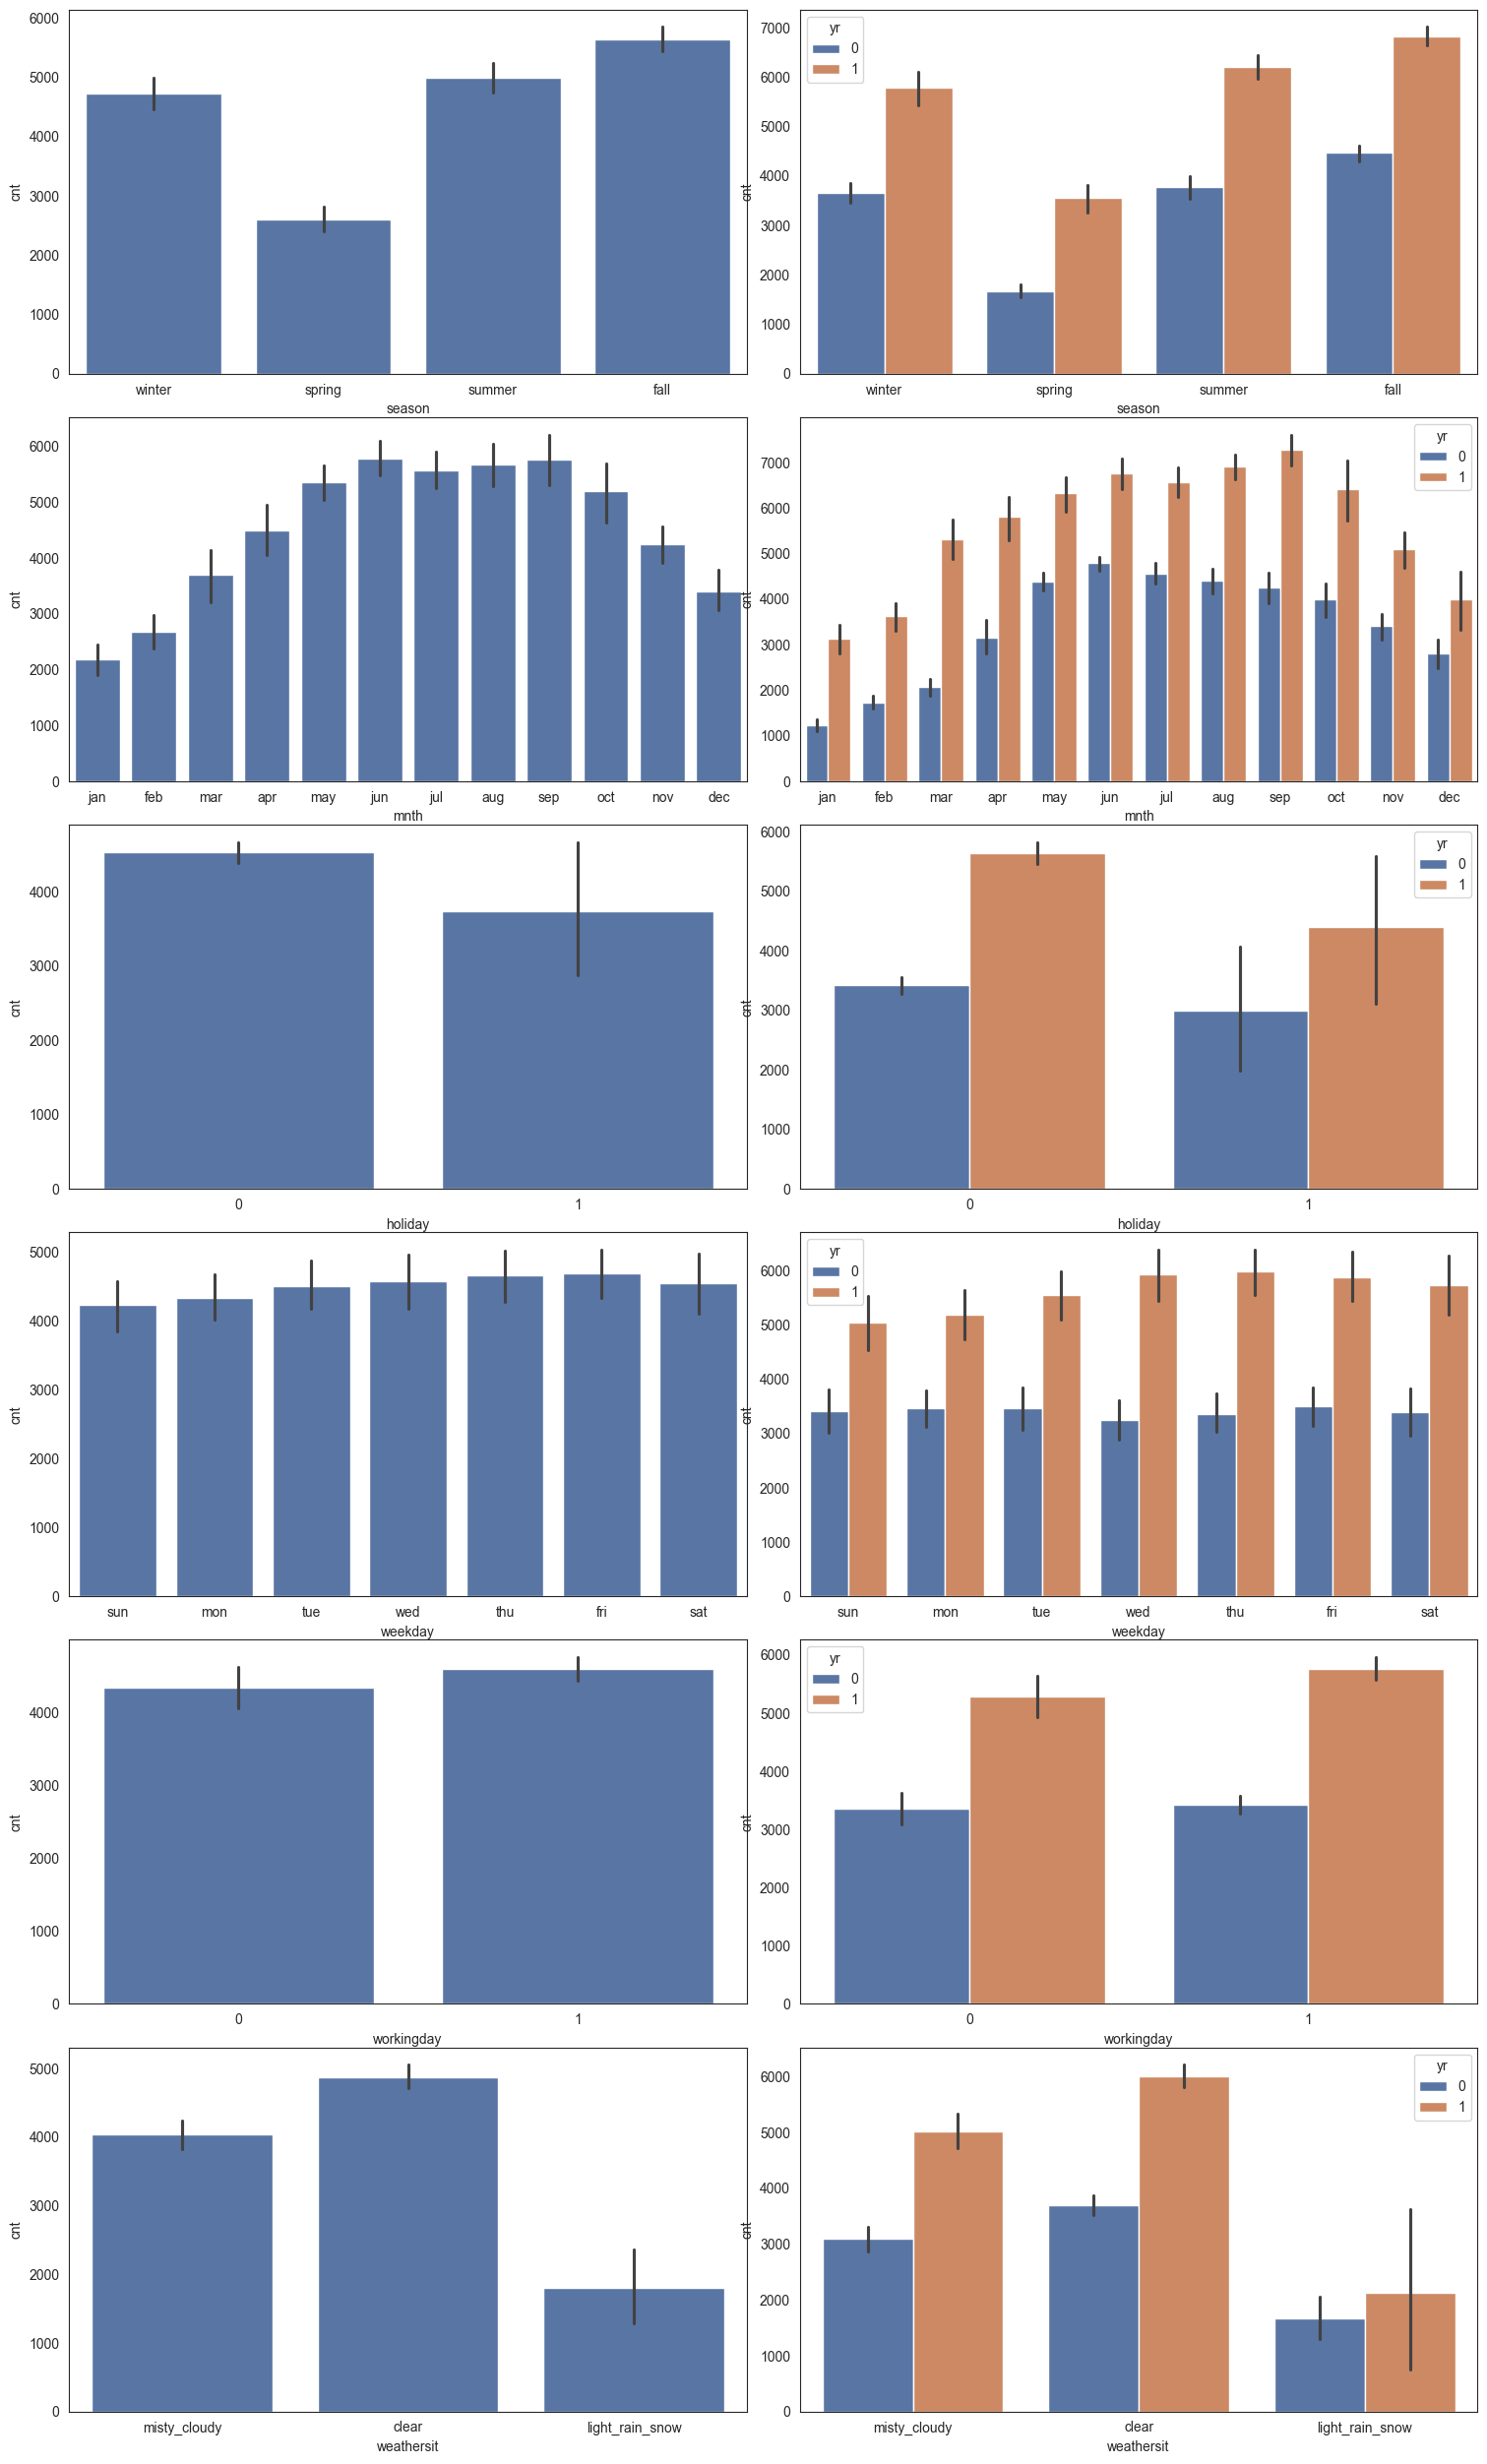

In [88]:
fig, ax = plt.subplots(6,2,figsize=(15, 25))
fig.tight_layout()
sns.barplot(data=bikes_df, x=cat[0],y="cnt", ax=ax[0][0], order=order_cat.get(cat[0]))
sns.barplot(data=bikes_df, x=cat[0],y="cnt", hue="yr", ax=ax[0][1], order=order_cat.get(cat[0]))

sns.barplot(data=bikes_df, x=cat[1],y="cnt", ax=ax[1][0], order=order_cat.get(cat[1]))
sns.barplot(data=bikes_df, x=cat[1],y="cnt", hue="yr", ax=ax[1][1], order=order_cat.get(cat[1]))

sns.barplot(data=bikes_df, x=cat[2],y="cnt", ax=ax[2][0], order=order_cat.get(cat[2]))
sns.barplot(data=bikes_df, x=cat[2],y="cnt", hue="yr", ax=ax[2][1], order=order_cat.get(cat[2]))

sns.barplot(data=bikes_df, x=cat[3],y="cnt", ax=ax[3][0], order=order_cat.get(cat[3]))
sns.barplot(data=bikes_df, x=cat[3],y="cnt", hue="yr", ax=ax[3][1], order=order_cat.get(cat[3]))

sns.barplot(data=bikes_df, x=cat[4],y="cnt", ax=ax[4][0], order=order_cat.get(cat[4]))
sns.barplot(data=bikes_df, x=cat[4],y="cnt", hue="yr", ax=ax[4][1], order=order_cat.get(cat[4]))

sns.barplot(data=bikes_df, x=cat[5],y="cnt", ax=ax[5][0], order=order_cat.get(cat[5]))
sns.barplot(data=bikes_df, x=cat[5],y="cnt", hue="yr", ax=ax[5][1], order=order_cat.get(cat[5]))

plt.show()

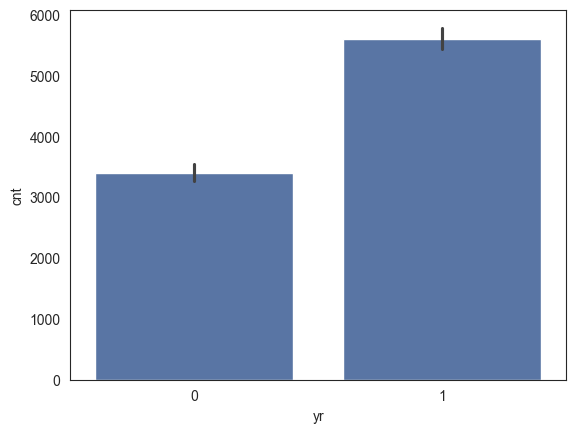

In [89]:
sns.barplot(data=bikes_df, x="yr",y="cnt")
plt.show()

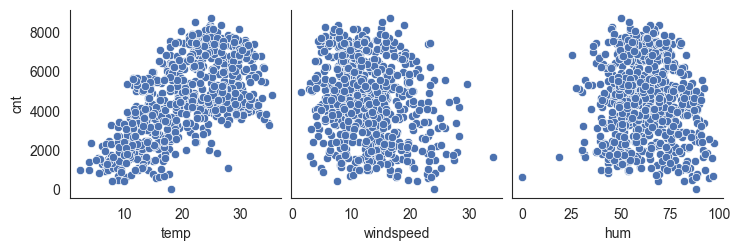

In [90]:
sns.pairplot(data=bikes_df, x_vars=['temp', 'windspeed', 'hum'], y_vars=['cnt'])
plt.show()

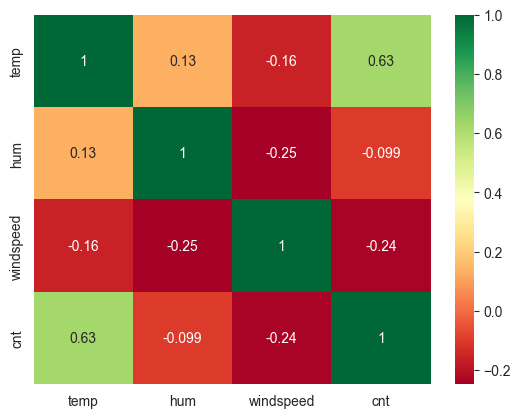

In [91]:
sns.heatmap(bikes_df[continuous].corr(), annot = True, cmap="RdYlGn")
plt.show()

### Data preparation

There are a lot of categorical variables. We will need to create dummy variables using the following rule

if there are k levels in the variable, create k-1 dummy variables. 

The variables like workingday / holiday are already satisfying the rule. We will need to look at the rest - season,mnts, weekday & weathersit

In [92]:
# Here drop_first ensures we maintain k-1 levels instead of k levels
seasons_data =pd.get_dummies(bikes_df['season'],drop_first=True)
mnths_data = pd.get_dummies(bikes_df['mnth'],drop_first=True)
weekdays_data =pd.get_dummies(bikes_df['weekday'],drop_first=True)
weathersit_data=pd.get_dummies(bikes_df['weathersit'],drop_first=True)

In [93]:
reg_df = pd.concat([bikes_df, seasons_data, mnths_data, weathersit_data, weekdays_data],axis=1)

In [94]:
# Drop the existing columns as these are no longer needed
reg_df.drop(['season', 'mnth', 'weekday', 'weathersit'], axis=1, inplace=True)

In [95]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yr               730 non-null    int64  
 1   holiday          730 non-null    int64  
 2   workingday       730 non-null    int64  
 3   temp             730 non-null    float64
 4   hum              730 non-null    float64
 5   windspeed        730 non-null    float64
 6   cnt              730 non-null    int64  
 7   spring           730 non-null    bool   
 8   summer           730 non-null    bool   
 9   winter           730 non-null    bool   
 10  aug              730 non-null    bool   
 11  dec              730 non-null    bool   
 12  feb              730 non-null    bool   
 13  jan              730 non-null    bool   
 14  jul              730 non-null    bool   
 15  jun              730 non-null    bool   
 16  mar              730 non-null    bool   
 17  may             

In [96]:
reg_df = reg_df.astype(float)

Now lets split data into train and train datasets

In [97]:
np.random.seed(1234) # To reproduce the same results
reg_train, reg_test = train_test_split(reg_df, train_size = 0.7, random_state = 100)

In [98]:
print(reg_train.shape)
print(reg_test.shape)

(510, 29)
(220, 29)


There are 510 rows in the train dataset and 220 in the test dataset

Now one last thing that we need to do is normalize the continuous features

In [99]:
min_max_scaler = MinMaxScaler()

In [100]:
# Note we will only do this on train data and not test. We don't want test data to learn from the training data
reg_train[continuous] = min_max_scaler.fit_transform(reg_train[continuous])

In [101]:
reg_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,...,oct,sep,light_rain_snow,misty_cloudy,mon,sat,sun,thu,tue,wed
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.650480,0.320883,0.513499,0.243137,0.247059,0.247059,...,0.084314,0.080392,0.029412,0.345098,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824
std,0.500429,0.157763,0.468282,0.225858,0.145846,0.169803,0.224421,0.429398,0.431725,0.431725,...,0.278131,0.272166,0.169124,0.475867,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Lets find the correlation of features with the target variable cnt

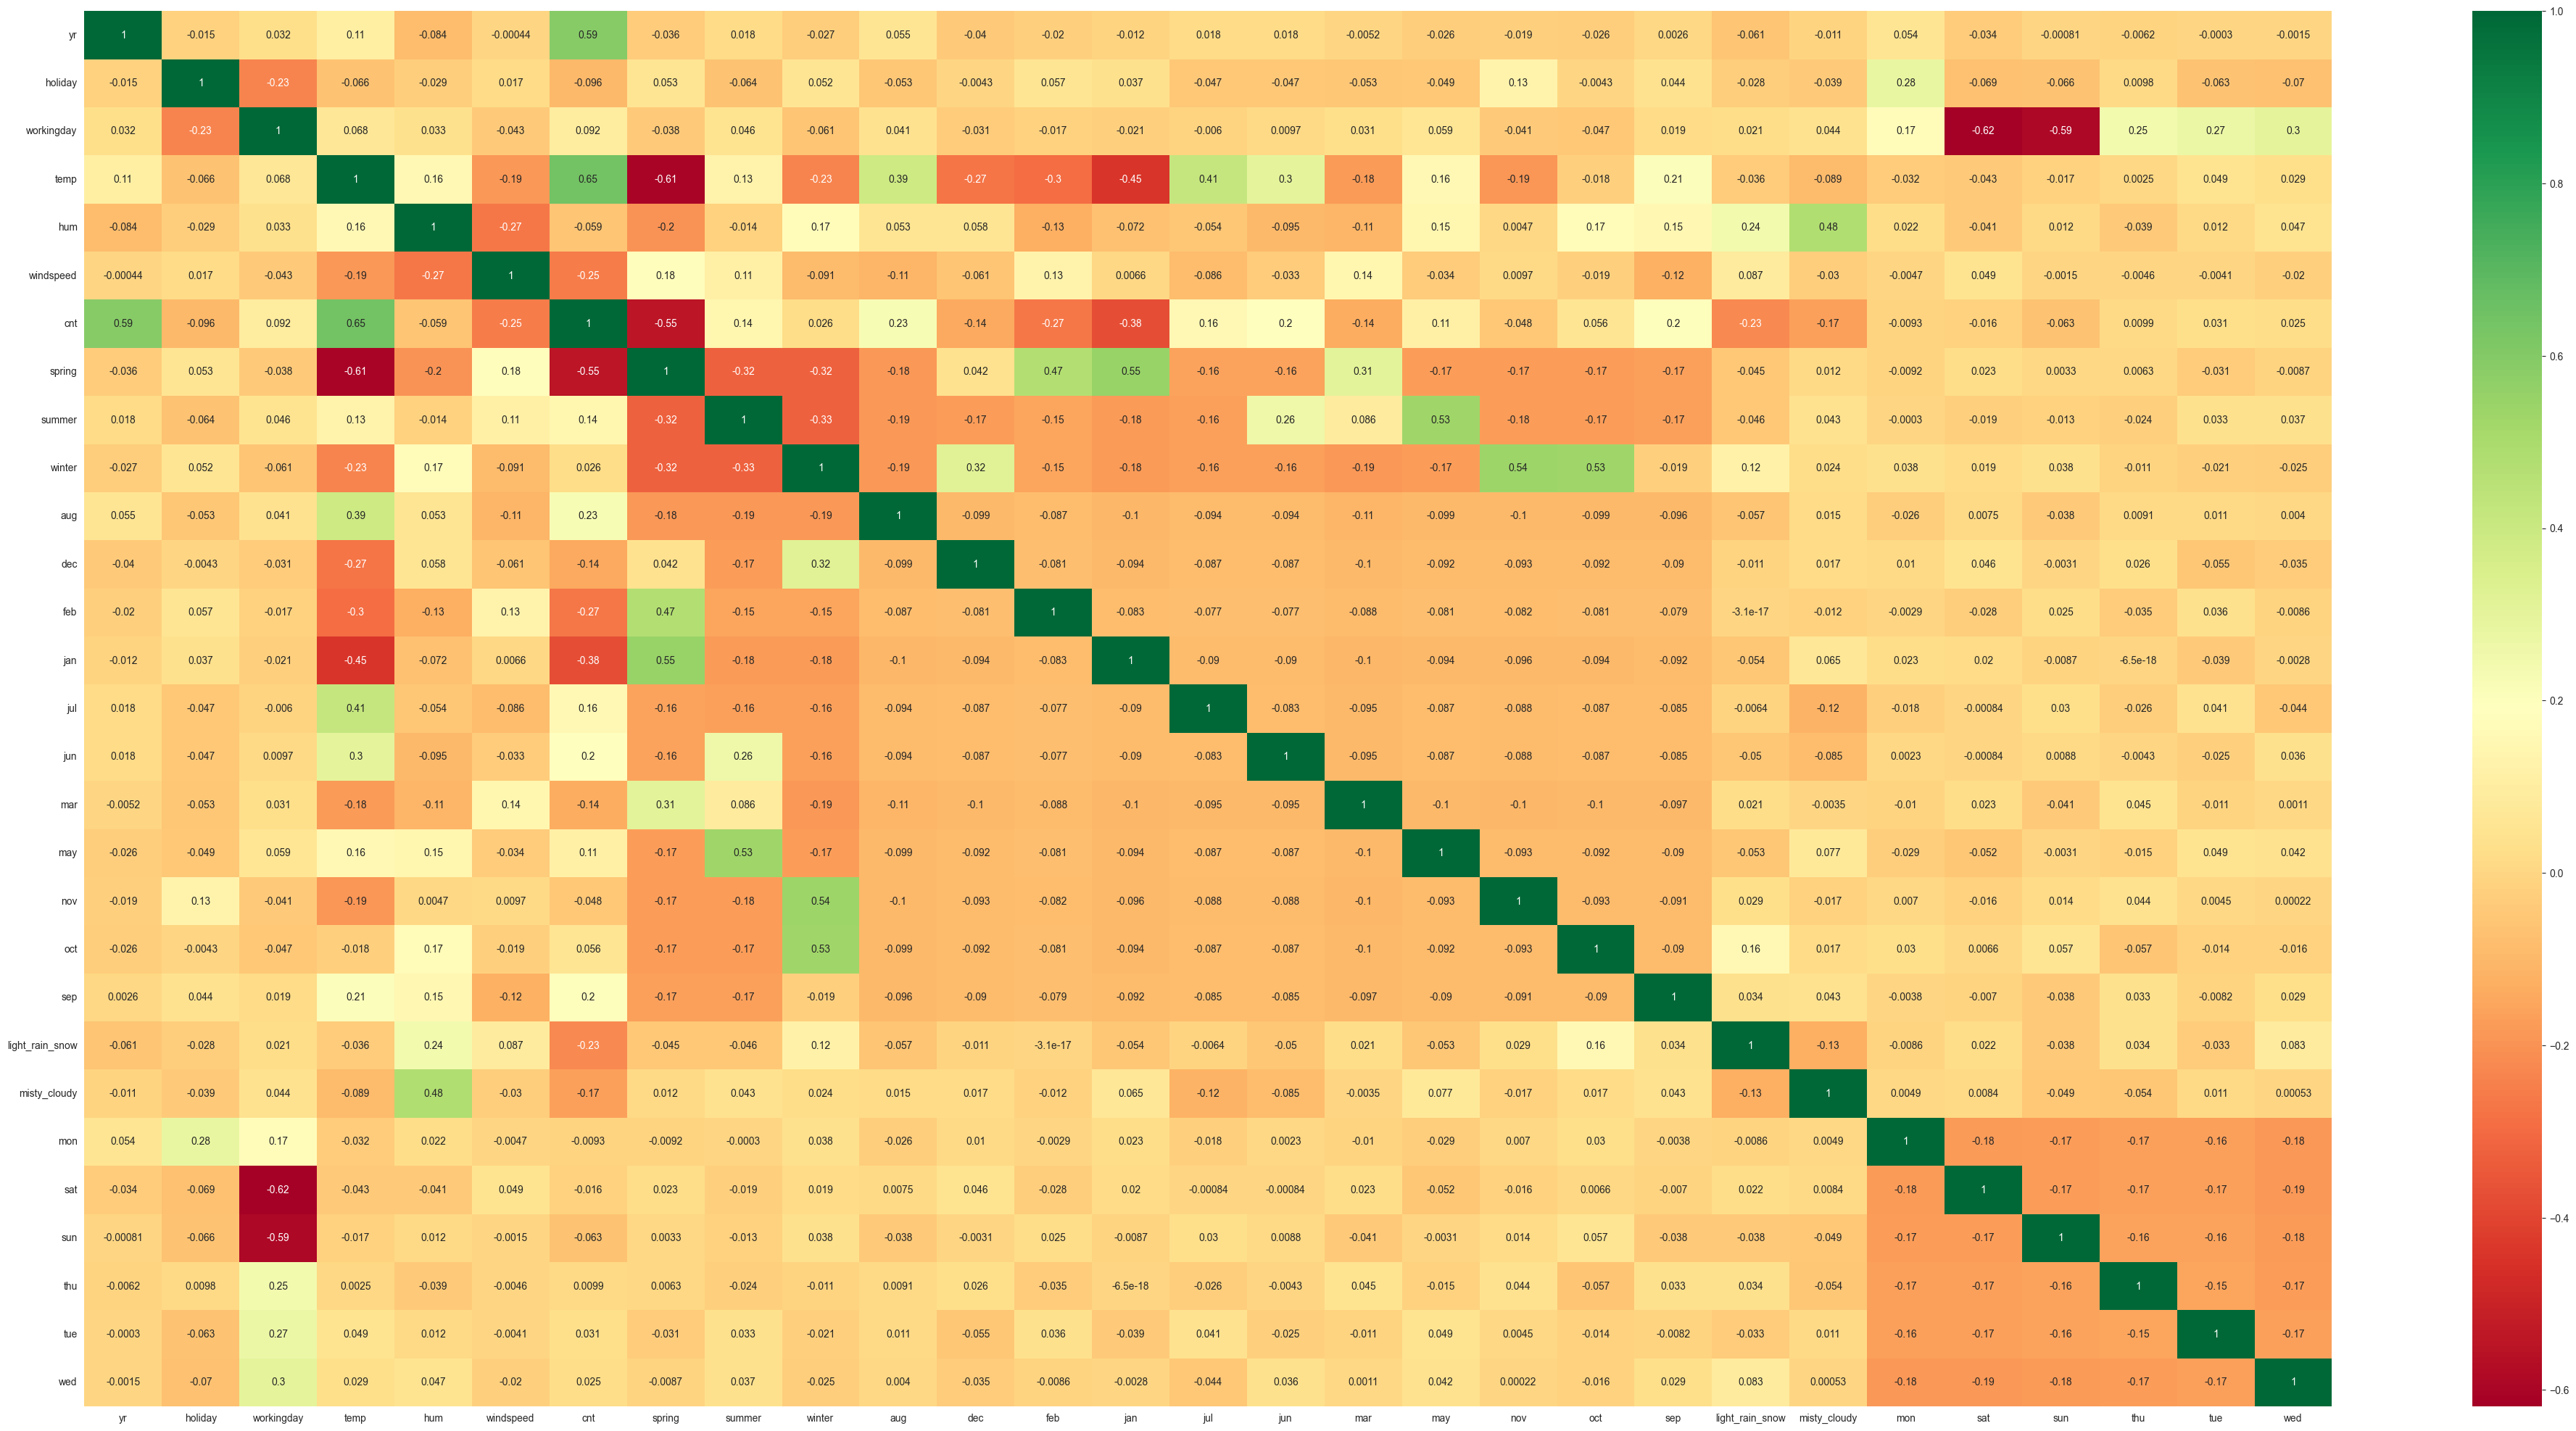

In [102]:
plt.figure(figsize = (50,25))
sns.heatmap(reg_train.corr(), annot = True, cmap="RdYlGn")
plt.show()

Based on the correlations, we can see the feature most positively correlated with cnt is temp

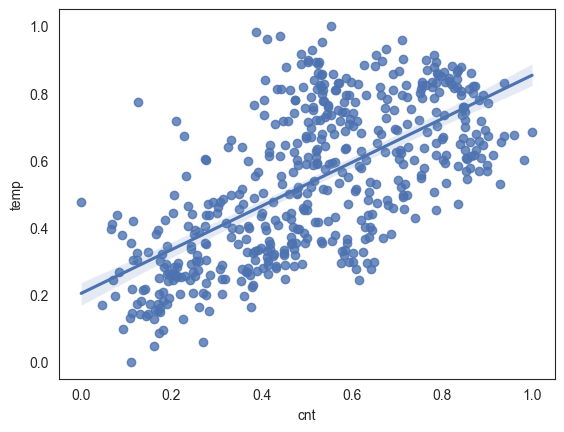

In [103]:
sns.regplot(data=reg_train, x="cnt", y="temp",)
plt.show()

### Building regression model

The dataset has very large number of features (29). All 29 of them may not be significant and will not aide in explaining the variance in our target variable. We will need to weed out some of those features. To do that we can use the technique **Recursive feature elimination**

Lets start with a target of 29/2 ~ 15 significant features 

In [104]:
def vif_score(df):
    vif = pd.DataFrame()
    vif['features'] = df.columns
    vif['vif'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['vif'] = round(vif['vif'], 2)
    vif = vif.sort_values(by = "vif", ascending = False)
    return vif 


def train_and_print_summary(train_df, y_train):
    X_train_sm = sm.add_constant(train_df)
    lr_model = sm.OLS(y_train,X_train_sm).fit()
    print(lr_model.summary())
    print(vif_score(train_df))
    return lr_model
    

In [105]:
reg_train_orig = reg_train.copy()
y_train = reg_train.pop("cnt")
X_train = reg_train

In [106]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
rfe = RFE(estimator=reg_model, n_features_to_select=15)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [107]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('aug', False, 10),
 ('dec', False, 4),
 ('feb', False, 5),
 ('jan', False, 2),
 ('jul', True, 1),
 ('jun', False, 9),
 ('mar', False, 8),
 ('may', False, 14),
 ('nov', False, 3),
 ('oct', False, 11),
 ('sep', True, 1),
 ('light_rain_snow', True, 1),
 ('misty_cloudy', True, 1),
 ('mon', False, 6),
 ('sat', True, 1),
 ('sun', True, 1),
 ('thu', False, 13),
 ('tue', False, 7),
 ('wed', False, 12)]

In [108]:
selected_columns = X_train.columns[rfe.support_]
rejected_columns = X_train.columns[~rfe.support_]
print(f"Selected columns: {selected_columns}")
print(f"Rejected columns: {rejected_columns}")

Selected columns: Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'summer', 'winter', 'jul', 'sep', 'light_rain_snow', 'misty_cloudy',
       'sat', 'sun'],
      dtype='object')
Rejected columns: Index(['aug', 'dec', 'feb', 'jan', 'jun', 'mar', 'may', 'nov', 'oct', 'mon',
       'thu', 'tue', 'wed'],
      dtype='object')


In [109]:
X_train = X_train[selected_columns]

Now that we have eliminated a few irrelevant features, we can build a model and analyse the significance of remaining features

In [110]:
train_and_print_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          2.11e-191
Time:                        18:41:07   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1995      0.028     

The pvalue for holiday is high hence lets drop it

In [111]:
X_train.drop('holiday', axis=1, inplace=True)

In [112]:
train_and_print_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          2.11e-191
Time:                        18:41:07   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1811      0.042     

Now that we have dropped holiday, the pvalue of the remaining features is less than 0.05. Then we look at the VIF score for the features and clearly for humidity "hum" its 32.1 which is greater than 5. Hence we have to drop "hum"

In [113]:
X_train.drop("hum", axis=1, inplace=True)
train_and_print_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     202.2
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          1.28e-188
Time:                        18:41:07   Log-Likelihood:                 508.20
No. Observations:                 510   AIC:                            -988.4
Df Residuals:                     496   BIC:                            -929.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1008      0.038     

Lets drop working day (VIF = 16.19)

In [114]:
X_train.drop("workingday", axis=1, inplace=True)
train_and_print_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     211.4
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          2.06e-186
Time:                        18:41:07   Log-Likelihood:                 500.18
No. Observations:                 510   AIC:                            -974.4
Df Residuals:                     497   BIC:                            -919.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2003      0.030     

Drop sat column since its pvalue (0.171) is insignificant

In [115]:
X_train.drop("sat", axis=1, inplace=True)
train_and_print_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.0
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          3.37e-187
Time:                        18:41:07   Log-Likelihood:                 499.22
No. Observations:                 510   AIC:                            -974.4
Df Residuals:                     498   BIC:                            -923.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2034      0.030     

The VIF for temp is 5.14 which is more than 5 but if we closely inspect this feature we see high positive correlation with the target variable. So lets not drop this. Instead lets look at the max pvalue variable available i.e jul

In [116]:
X_train.drop("jul", axis=1, inplace=True)
final_model = train_and_print_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     249.5
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          5.70e-187
Time:                        18:41:07   Log-Likelihood:                 495.81
No. Observations:                 510   AIC:                            -969.6
Df Residuals:                     499   BIC:                            -923.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1956      0.030     

Now we are at a state where VIF scores are within limit of 5 and pvalues are all sigificant. Also our adjusted R^2 is also good ~ 0.83 . The f statistic also confirms that our model is significant

#### Residual Analysis

In [117]:
X_train_sm = sm.add_constant(X_train)
y_train_pred = final_model.predict(X_train_sm)

In [118]:
error_terms = y_train - y_train_pred

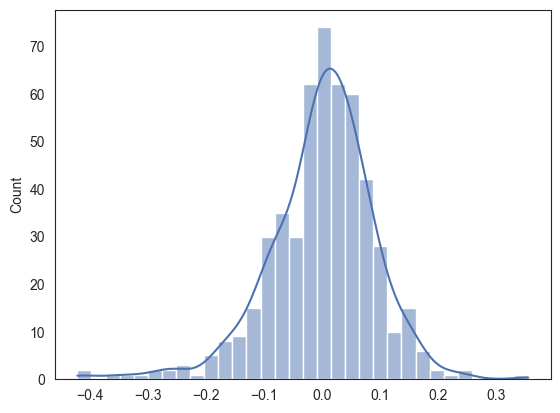

In [119]:
sns.histplot(error_terms, kde=True)
plt.show()

As we can observe the error terms are normally distributed with a mean near 0. Hence Normality of the error terms is verified

In [120]:
vif_score(X_train)

,features,vif
2,windspeed,4.59
1,temp,3.90
0,yr,2.07
3,spring,2.00
4,summer,1.91
5,winter,1.64
8,misty_cloudy,1.55
6,sep,1.22
9,sun,1.17
7,light_rain_snow,1.08


All VIF scores are within the value of 5. Hence no multicolinearity in the feature set.

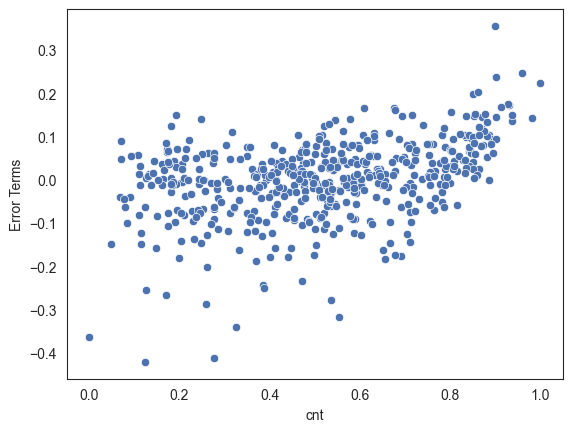

In [124]:
sns.scatterplot(x=y_train,y=error_terms)
plt.ylabel('Error Terms')
plt.show()

No visible patterns in the residuals hence validating homoscedasticity

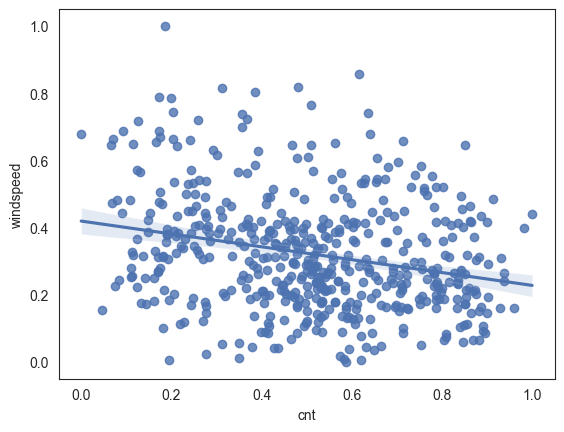

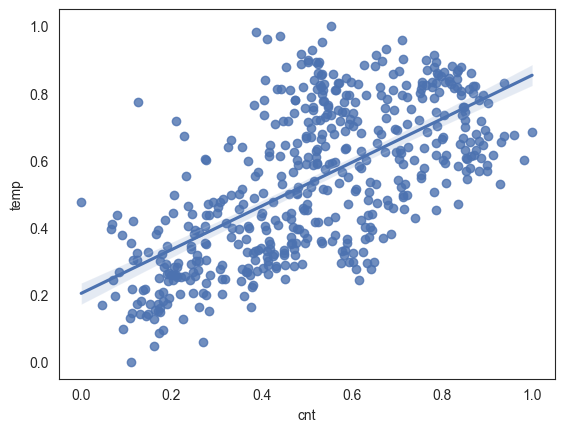

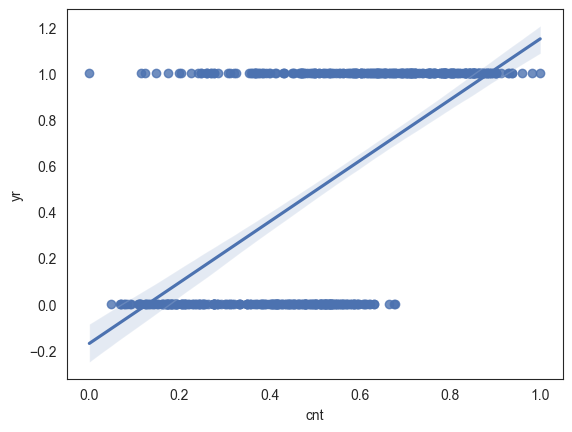

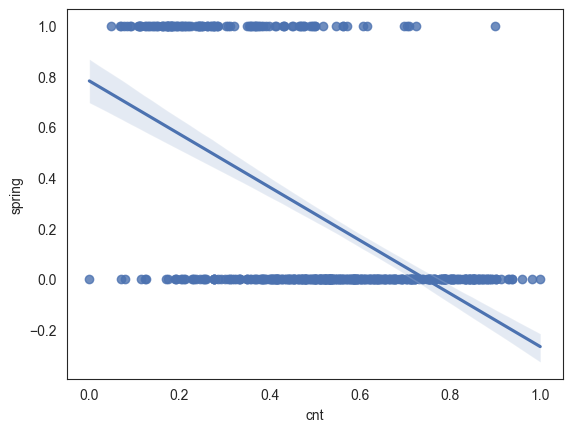

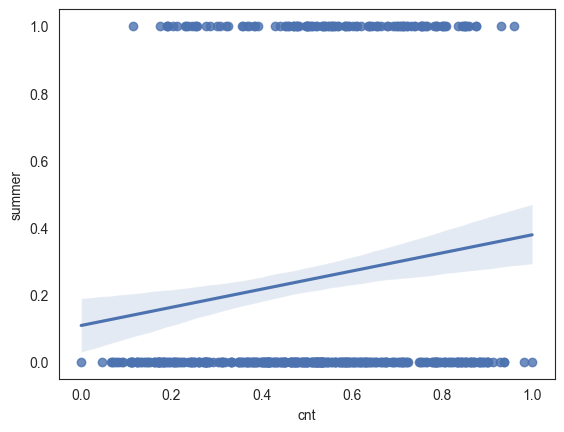

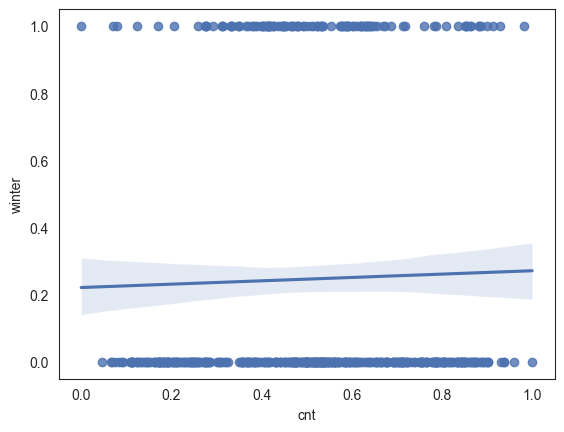

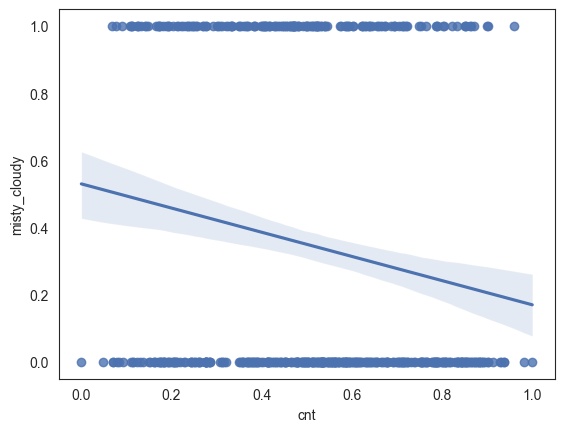

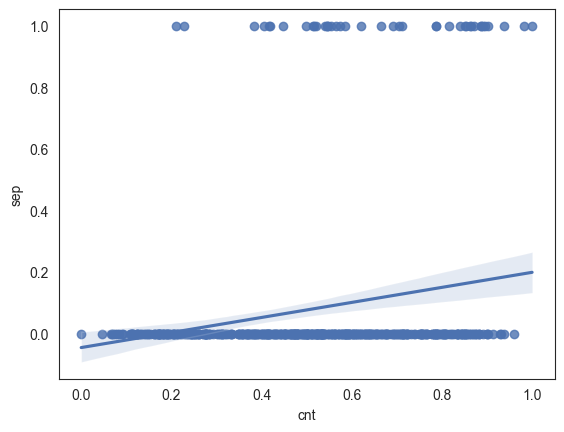

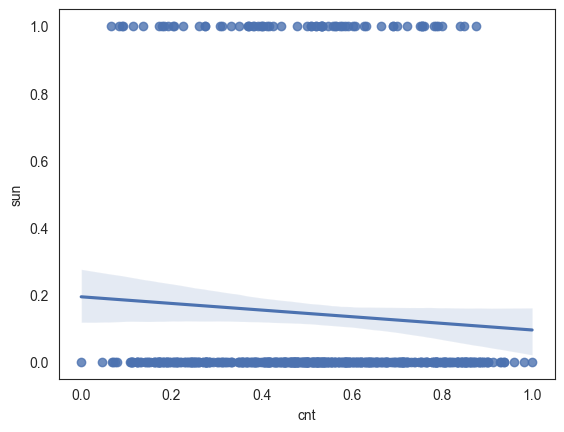

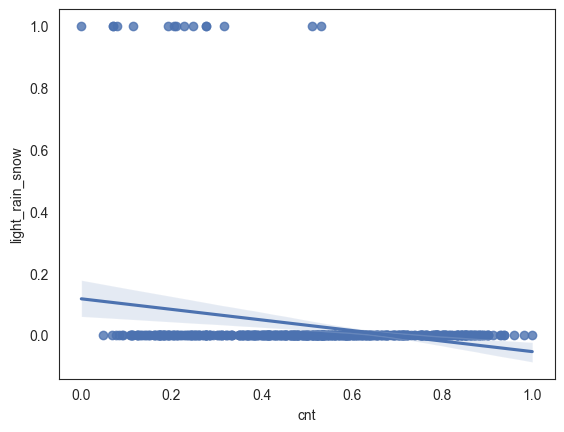

In [123]:
chosen = ['windspeed', 'temp', 'yr', 'spring','summer', 'winter', 'misty_cloudy', 'sep', 'sun', 'light_rain_snow']

for c in chosen:
    sns.regplot(data=reg_train_orig, x="cnt", y=c)
    plt.show()


[]

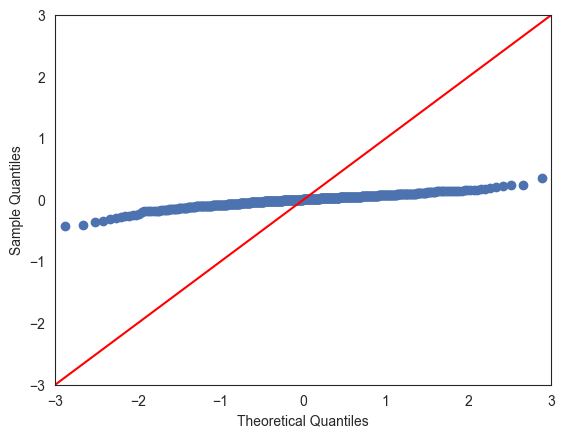

#### Predictions on test dataset

In [ ]:
# first scale test dataset based on train scaler
reg_test[continuous] = min_max_scaler.transform(reg_test[continuous])

In [ ]:
y_test = reg_test.pop("cnt")
X_test = reg_test

In [ ]:
X_test = X_test[X_train.columns]

In [ ]:
X_test_sm = sm.add_constant(X_test)
y_test_pred = final_model.predict(X_test_sm)

In [ ]:
# Find R^2 score
r2 = r2_score(y_test, y_test_pred)
print(round(r2,3))

0.803


In [ ]:
r2_adj = 1 - ((1-r2) * (X_test.shape[0] - 1) / (X_test.shape[0]-X_test.shape[1]-1))
r2_adj = round(r2_adj,3)
print(r2_adj)

0.794


In [130]:
print(round(final_model.params,3))

const              0.196
yr                 0.234
temp               0.479
windspeed         -0.150
spring            -0.057
summer             0.062
winter             0.094
sep                0.085
light_rain_snow   -0.286
misty_cloudy      -0.079
sun               -0.046
dtype: float64


In [133]:
feature_coeff = list(zip(round(final_model.params,3),final_model.params.index))
feature_importance = [(abs(x[0]),x[1]) for x in feature_coeff]
feature_importance.sort(key=lambda x: x[0], reverse=True)
print(feature_importance)

[(0.479, 'temp'), (0.286, 'light_rain_snow'), (0.234, 'yr'), (0.196, 'const'), (0.15, 'windspeed'), (0.094, 'winter'), (0.085, 'sep'), (0.079, 'misty_cloudy'), (0.062, 'summer'), (0.057, 'spring'), (0.046, 'sun')]


#### Final Results

On Training Data
- R^2 = 0.833
- Adj R^2 = 0.83

On Test Data
- R^2 = 0.803
- Adj R^2 = 0.794

As per the above metrics, our model performs well on the unseen test data set